# Correlations and spread in ensemble

## Preliminaries

### Load packages

In [1]:
import numpy as np
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [2]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [3]:
from post_processing_fns import *

In [4]:
## Which vertical columns are we considering here?
which_columns = {
  'lons' : [-174.5, 45.5, 75.5, -129.5, 160.5],
  'lats' : [-29.5, -59.5, -24.5, 0.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific', 'southern_ocean', 'indian_ocean', 'tropical_pacific', 'north_pacific']
}
which_columns2 = {
  'lons' : [-154.5, 35.5, 75.5, -150.5, 160.5],
  'lats' : [-27.5, -49.5, -31.5, 12.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific2', 'southern_ocean2', 'indian_ocean2', 'tropical_pacific2', 'north_pacific']
}
sergey_columns = {
  'lons' : [-150.0, 160.0, 75.0,  -110.0],
  'lats' : [3.0,    40.0,  -24.0, -30.0],
  'name' : ['Tropical East Pacific', 'Kuroshio', 'Indian Ocean', 'South Pacific'],
  'save_name' : ['tepac', 'kuroshio', 'io', 'spac']
}

### Change directories here

In [5]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots/20151206.030000'
my_data_dir = proj_dir + '/my_data/20151206.030000'
nb_dir = proj_dir + '/notebooks'

### Change which columns we are using here

In [6]:
these_columns = which_columns2

## Correlations

### Map of sst and t2m correlation

In [7]:
sst_ast_corr = xr.open_dataset(my_data_dir+'/sst_ast_corr.nc')

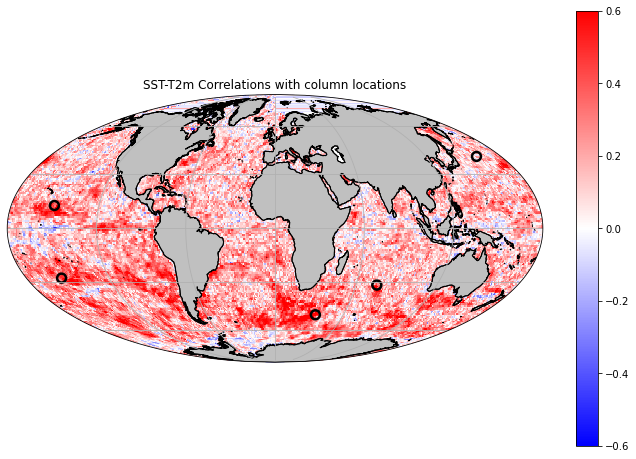

In [44]:
## Save a map of the world showing column locations
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_global()
im = ax.pcolormesh(sst_ast_corr['lon'], sst_ast_corr['lat'], sst_ast_corr['__xarray_dataarray_variable__'], vmin=-0.6, vmax=0.6, cmap='bwr', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='silver'))
plt.colorbar(im)
plt.title('SST-T2m Correlations with column locations')
ax.coastlines(resolution='110m')
ax.gridlines()
ax.scatter(these_columns['lons'], these_columns['lats'],transform=ccrs.PlateCarree(),facecolors='none', edgecolors='k', s=80, linewidth=2.5)

plt.rcParams['figure.figsize'] = [12,6]
plt.savefig(plot_dir+'/sst_ast_corr_with_column_locations.png')
plt.show()

### Load data

In [9]:
## Load vertical columns
south_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][0]+'.nc')
southern_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][1]+'.nc')
indian_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][2]+'.nc')
tropical_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][3]+'.nc')
north_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][4]+'.nc')

In [10]:
# Load covariance matrices
sp_cov = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cov.npy')
so_cov = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cov.npy')
io_cov = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cov.npy')
tp_cov = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cov.npy')
np_cov = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cov.npy')

In [11]:
# Load correlation matrices
sp_cor = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cor.npy')
so_cor = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cor.npy')
io_cor = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cor.npy')
tp_cor = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cor.npy')
np_cor = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cor.npy')

### Compute correlations

In [12]:
## South Pacific
sp_corr = xr.Dataset()
sp_corr['sst_atm_T'] = xr.corr(south_pacific['sst'], south_pacific['atm_T'], dim = 'ens_mem')
sp_corr['sst_ocn_T'] = xr.corr(south_pacific['sst'], south_pacific['ocn_Temp'], dim = 'ens_mem')
sp_corr['ast_atm_T'] = xr.corr(south_pacific['atm_t2m'], south_pacific['atm_T'], dim = 'ens_mem')
sp_corr['ast_ocn_T'] = xr.corr(south_pacific['atm_t2m'], south_pacific['ocn_Temp'], dim = 'ens_mem')
sp_corr['atm_p'] = south_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
sp_corr = sp_corr.mean(['lat', 'lon'])

## Southern Ocean
so_corr = xr.Dataset()
so_corr['sst_atm_T'] = xr.corr(southern_ocean['sst'], southern_ocean['atm_T'], dim = 'ens_mem')
so_corr['sst_ocn_T'] = xr.corr(southern_ocean['sst'], southern_ocean['ocn_Temp'], dim = 'ens_mem')
so_corr['ast_atm_T'] = xr.corr(southern_ocean['atm_t2m'], southern_ocean['atm_T'], dim = 'ens_mem')
so_corr['ast_ocn_T'] = xr.corr(southern_ocean['atm_t2m'], southern_ocean['ocn_Temp'], dim = 'ens_mem')
so_corr['atm_p'] = southern_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
so_corr = so_corr.mean(['lat', 'lon'])

## Indian Ocean
io_corr = xr.Dataset()
io_corr['sst_atm_T'] = xr.corr(indian_ocean['sst'], indian_ocean['atm_T'], dim = 'ens_mem')
io_corr['sst_ocn_T'] = xr.corr(indian_ocean['sst'], indian_ocean['ocn_Temp'], dim = 'ens_mem')
io_corr['ast_atm_T'] = xr.corr(indian_ocean['atm_t2m'], indian_ocean['atm_T'], dim = 'ens_mem')
io_corr['ast_ocn_T'] = xr.corr(indian_ocean['atm_t2m'], indian_ocean['ocn_Temp'], dim = 'ens_mem')
io_corr['atm_p'] = indian_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
io_corr = io_corr.mean(['lat', 'lon'])

## Tropical Pacific
tp_corr = xr.Dataset()
tp_corr['sst_atm_T'] = xr.corr(tropical_pacific['sst'], tropical_pacific['atm_T'], dim = 'ens_mem')
tp_corr['sst_ocn_T'] = xr.corr(tropical_pacific['sst'], tropical_pacific['ocn_Temp'], dim = 'ens_mem')
tp_corr['ast_atm_T'] = xr.corr(tropical_pacific['atm_t2m'], tropical_pacific['atm_T'], dim = 'ens_mem')
tp_corr['ast_ocn_T'] = xr.corr(tropical_pacific['atm_t2m'], tropical_pacific['ocn_Temp'], dim = 'ens_mem')
tp_corr['atm_p'] = tropical_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
tp_corr = tp_corr.mean(['lat', 'lon'])

## North Pacific
np_corr = xr.Dataset()
np_corr['sst_atm_T'] = xr.corr(north_pacific['sst'], north_pacific['atm_T'], dim = 'ens_mem')
np_corr['sst_ocn_T'] = xr.corr(north_pacific['sst'], north_pacific['ocn_Temp'], dim = 'ens_mem')
np_corr['ast_atm_T'] = xr.corr(north_pacific['atm_t2m'], north_pacific['atm_T'], dim = 'ens_mem')
np_corr['ast_ocn_T'] = xr.corr(north_pacific['atm_t2m'], north_pacific['ocn_Temp'], dim = 'ens_mem')
np_corr['atm_p'] = north_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
np_corr = np_corr.mean(['lat', 'lon'])

In [13]:
## Get indices
# atmosphere
num_atm_levs = len(south_pacific['atm_lev'])
indt2m = num_atm_levs - 1
ind100hPa = np.argmin(np.abs(sp_corr['atm_p'].values-100))
# ocean
ind0m = num_atm_levs
ind150m_ocn = np.argmin(np.abs(sp_corr['ocn_lev'].values-150))
ind150m = ind0m + ind150m_ocn
num_ocn_levs = len(south_pacific['ocn_lev'])

### Mean temperature profiles

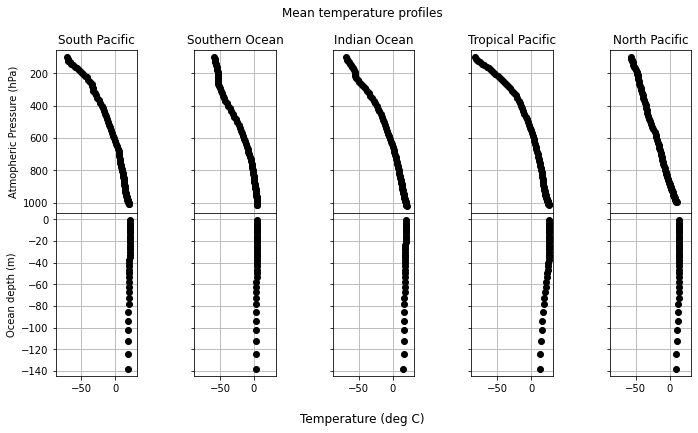

In [14]:
## Create subplots
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey='row') 

# Plot atm temperature
axs[0, 0].plot(south_pacific['atm_T'].mean(['lat', 'lon', 'ens_mem'])[ind100hPa:]-273.15, sp_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 1].plot(southern_ocean['atm_T'].mean(['lat', 'lon', 'ens_mem'])[ind100hPa:]-273.15, so_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 2].plot(indian_ocean['atm_T'].mean(['lat', 'lon', 'ens_mem'])[ind100hPa:]-273.15, io_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 3].plot(tropical_pacific['atm_T'].mean(['lat', 'lon', 'ens_mem'])[ind100hPa:]-273.15, tp_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 4].plot(north_pacific['atm_T'].mean(['lat', 'lon', 'ens_mem'])[ind100hPa:]-273.15, np_corr['atm_p'][ind100hPa:], 'ko')

# Plot ocn temperature
axs[1, 0].plot(south_pacific['ocn_Temp'].mean(['lat', 'lon', 'ens_mem'])[:ind150m_ocn], -1 * sp_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 1].plot(southern_ocean['ocn_Temp'].mean(['lat', 'lon', 'ens_mem'])[:ind150m_ocn], -1 * so_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 2].plot(indian_ocean['ocn_Temp'].mean(['lat', 'lon', 'ens_mem'])[:ind150m_ocn], -1 * io_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 3].plot(tropical_pacific['ocn_Temp'].mean(['lat', 'lon', 'ens_mem'])[:ind150m_ocn], -1 * tp_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 4].plot(north_pacific['ocn_Temp'].mean(['lat', 'lon', 'ens_mem'])[:ind150m_ocn], -1 * np_corr['ocn_lev'][:ind150m_ocn], 'ko')

# Set titles
axs[0,0].set_title('South Pacific')
axs[0,1].set_title('Southern Ocean')
axs[0,2].set_title('Indian Ocean')
axs[0,3].set_title('Tropical Pacific')
axs[0,4].set_title('North Pacific')

# Adjust axes
axs[0, 0].invert_yaxis()

# Adjust and label axes
#axs[0, 0].set_xlim([-0.5, 1.1])
axs[0, 0].set_ylabel('Atmopheric Pressure (hPa)')
axs[1, 0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Temperature (deg C)')
fig.suptitle('Mean temperature profiles')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_mean_atm_ocn_five_columns')
plt.show()

### Correlation between SST and temperature

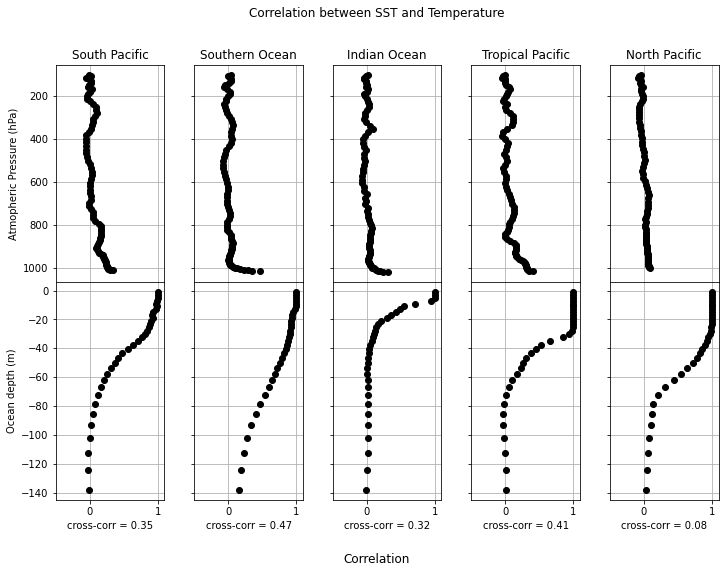

In [15]:
## Create subplots
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey='row') 

# Plot atm correlations
axs[0, 0].plot(sp_corr['sst_atm_T'][ind100hPa:], sp_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 1].plot(so_corr['sst_atm_T'][ind100hPa:], so_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 2].plot(io_corr['sst_atm_T'][ind100hPa:], io_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 3].plot(tp_corr['sst_atm_T'][ind100hPa:], tp_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 4].plot(np_corr['sst_atm_T'][ind100hPa:], np_corr['atm_p'][ind100hPa:], 'ko')

# Plot ocn correlations
axs[1, 0].plot(sp_corr['sst_ocn_T'][:ind150m_ocn], -1 * sp_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 1].plot(so_corr['sst_ocn_T'][:ind150m_ocn], -1 * so_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 2].plot(io_corr['sst_ocn_T'][:ind150m_ocn], -1 * io_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 3].plot(tp_corr['sst_ocn_T'][:ind150m_ocn], -1 * tp_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 4].plot(np_corr['sst_ocn_T'][:ind150m_ocn], -1 * np_corr['ocn_lev'][:ind150m_ocn], 'ko')

# Set titles
axs[0,0].set_title('South Pacific')
axs[0,1].set_title('Southern Ocean')
axs[0,2].set_title('Indian Ocean')
axs[0,3].set_title('Tropical Pacific')
axs[0,4].set_title('North Pacific')

# Add correlation
axs[1,0].set_xlabel('cross-corr = '+str('%.2f'%sp_corr['sst_atm_T'][indt2m].values))
axs[1,1].set_xlabel('cross-corr = '+str('%.2f'%so_corr['sst_atm_T'][indt2m].values))
axs[1,2].set_xlabel('cross-corr = '+str('%.2f'%io_corr['sst_atm_T'][indt2m].values))
axs[1,3].set_xlabel('cross-corr = '+str('%.2f'%tp_corr['sst_atm_T'][indt2m].values))
axs[1,4].set_xlabel('cross-corr = '+str('%.2f'%np_corr['sst_atm_T'][indt2m].values))

# Adjust axes
axs[0, 0].invert_yaxis()
#axs[0, 0].set_yscale('log')
#axs[1, 0].set_yscale('symlog')

# Adjust and label axes
axs[0, 0].set_xlim([-0.5, 1.1])
axs[0, 0].set_ylabel('Atmopheric Pressure (hPa)')
axs[1, 0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Correlation')
fig.suptitle('Correlation between SST and Temperature')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/sst_temp_corr_five_columns')
plt.show()

### Correlations between T2m and temperature

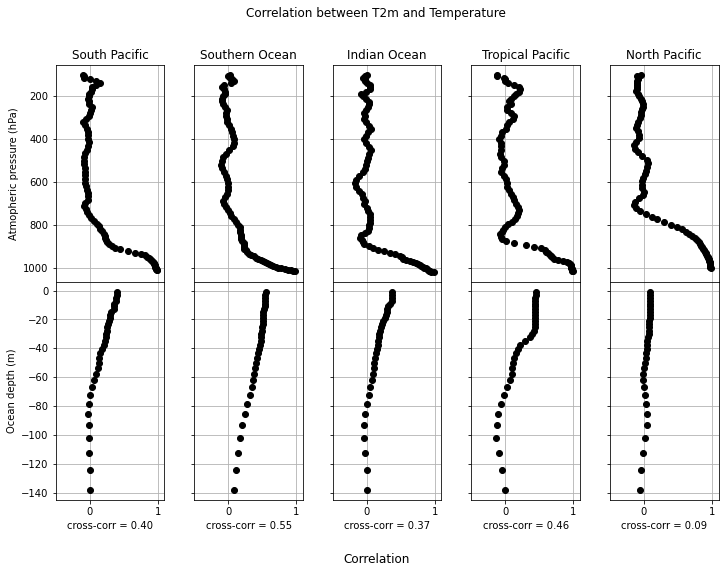

In [16]:
## Create subplots
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey='row') 

# Plot atm correlations
axs[0, 0].plot(sp_corr['ast_atm_T'][ind100hPa:], sp_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 1].plot(so_corr['ast_atm_T'][ind100hPa:], so_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 2].plot(io_corr['ast_atm_T'][ind100hPa:], io_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 3].plot(tp_corr['ast_atm_T'][ind100hPa:], tp_corr['atm_p'][ind100hPa:], 'ko')
axs[0, 4].plot(np_corr['ast_atm_T'][ind100hPa:], np_corr['atm_p'][ind100hPa:], 'ko')

# Plot ocn correlations
axs[1, 0].plot(sp_corr['ast_ocn_T'][:ind150m_ocn], -1 * sp_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 1].plot(so_corr['ast_ocn_T'][:ind150m_ocn], -1 * so_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 2].plot(io_corr['ast_ocn_T'][:ind150m_ocn], -1 * io_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 3].plot(tp_corr['ast_ocn_T'][:ind150m_ocn], -1 * tp_corr['ocn_lev'][:ind150m_ocn], 'ko')
axs[1, 4].plot(np_corr['ast_ocn_T'][:ind150m_ocn], -1 * np_corr['ocn_lev'][:ind150m_ocn], 'ko')

# Set titles
axs[0,0].set_title('South Pacific')
axs[0,1].set_title('Southern Ocean')
axs[0,2].set_title('Indian Ocean')
axs[0,3].set_title('Tropical Pacific')
axs[0,4].set_title('North Pacific')

# Add correlation
axs[1,0].set_xlabel('cross-corr = '+str('%.2f'%sp_corr['ast_ocn_T'][0].values))
axs[1,1].set_xlabel('cross-corr = '+str('%.2f'%so_corr['ast_ocn_T'][0].values))
axs[1,2].set_xlabel('cross-corr = '+str('%.2f'%io_corr['ast_ocn_T'][0].values))
axs[1,3].set_xlabel('cross-corr = '+str('%.2f'%tp_corr['ast_ocn_T'][0].values))
axs[1,4].set_xlabel('cross-corr = '+str('%.2f'%np_corr['ast_ocn_T'][0].values))

# Adjust axes
axs[0, 0].invert_yaxis()
#axs[0, 0].set_yscale('log')
#axs[1, 0].set_yscale('symlog')

# Adjust and label axes
axs[0, 0].set_xlim([-0.5, 1.1])
axs[0, 0].set_ylabel('Atmopheric pressure (hPa)')
axs[1, 0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Correlation')
fig.suptitle('Correlation between T2m and Temperature')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/ast_temp_corr_five_columns')
plt.show()

## Spread in ensemble

### Profiles of mean temperature for each column

In [17]:
## Average over ensemble members and show the mean at each location

# South Pacific
sp_ocn_temp = south_pacific['ocn_Temp'].mean('ens_mem').to_numpy()
sp_ocn_temp = sp_ocn_temp.reshape(num_ocn_levs, 25)
sp_atm_temp = south_pacific['atm_T'].mean('ens_mem').to_numpy()
sp_atm_temp = sp_atm_temp.reshape(num_atm_levs, 25)

# Southern Ocean
so_ocn_temp = southern_ocean['ocn_Temp'].mean('ens_mem').to_numpy()
so_ocn_temp = so_ocn_temp.reshape(num_ocn_levs, 25)
so_atm_temp = southern_ocean['atm_T'].mean('ens_mem').to_numpy()
so_atm_temp = so_atm_temp.reshape(num_atm_levs, 25)

# Indian Ocean
io_ocn_temp = indian_ocean['ocn_Temp'].mean('ens_mem').to_numpy()
io_ocn_temp = io_ocn_temp.reshape(num_ocn_levs, 25)
io_atm_temp = indian_ocean['atm_T'].mean('ens_mem').to_numpy()
io_atm_temp = io_atm_temp.reshape(num_atm_levs, 25)

# Tropical Pacific
tp_ocn_temp = tropical_pacific['ocn_Temp'].mean('ens_mem').to_numpy()
tp_ocn_temp = tp_ocn_temp.reshape(num_ocn_levs, 25)
tp_atm_temp = tropical_pacific['atm_T'].mean('ens_mem').to_numpy()
tp_atm_temp = tp_atm_temp.reshape(num_atm_levs, 25)

# North Pacific
np_ocn_temp = north_pacific['ocn_Temp'].mean('ens_mem').to_numpy()
np_ocn_temp = np_ocn_temp.reshape(num_ocn_levs, 25)
np_atm_temp = north_pacific['atm_T'].mean('ens_mem').to_numpy()
np_atm_temp = np_atm_temp.reshape(num_atm_levs, 25)

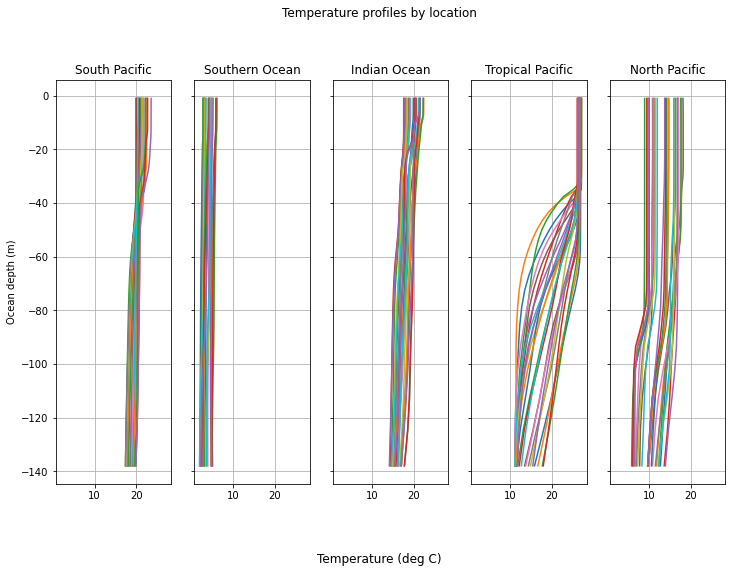

In [18]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot ocn temperature
axs[0].plot(sp_ocn_temp[:ind150m_ocn], -1 * sp_corr['ocn_lev'][:ind150m_ocn])
axs[1].plot(so_ocn_temp[:ind150m_ocn], -1 * so_corr['ocn_lev'][:ind150m_ocn])
axs[2].plot(io_ocn_temp[:ind150m_ocn], -1 * io_corr['ocn_lev'][:ind150m_ocn])
axs[3].plot(tp_ocn_temp[:ind150m_ocn], -1 * tp_corr['ocn_lev'][:ind150m_ocn])
axs[4].plot(np_ocn_temp[:ind150m_ocn], -1 * np_corr['ocn_lev'][:ind150m_ocn])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
axs[0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Temperature (deg C)')
fig.suptitle('Temperature profiles by location')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_mean_ocn150m_five_columns')
plt.show()

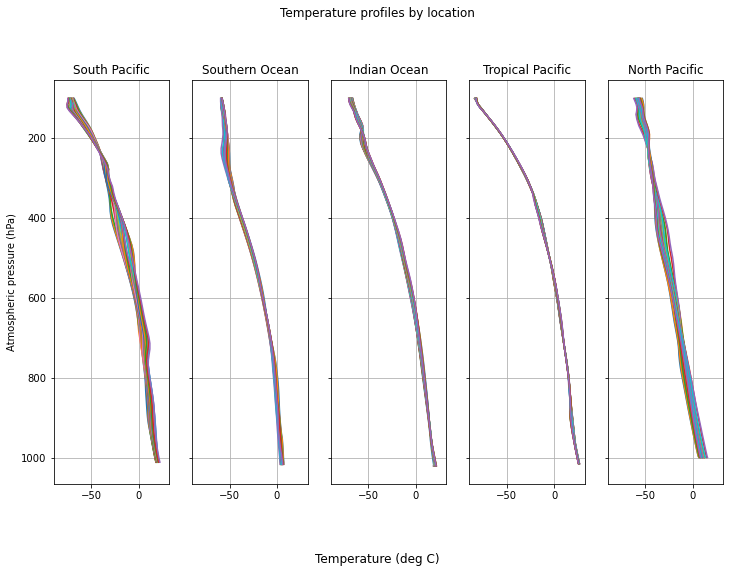

In [19]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot atm temperature

axs[0].plot(sp_atm_temp[ind100hPa:] - 273.15, sp_corr['atm_p'][ind100hPa:])
axs[1].plot(so_atm_temp[ind100hPa:] - 273.15, so_corr['atm_p'][ind100hPa:])
axs[2].plot(io_atm_temp[ind100hPa:] - 273.15, io_corr['atm_p'][ind100hPa:])
axs[3].plot(tp_atm_temp[ind100hPa:] - 273.15, tp_corr['atm_p'][ind100hPa:])
axs[4].plot(np_atm_temp[ind100hPa:] - 273.15, np_corr['atm_p'][ind100hPa:])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
#axs[0].set_yscale('log')
plt.gca().invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Temperature (deg C)')
fig.suptitle('Temperature profiles by location')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)
    

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_mean_atm_five_columns')
plt.show()

### Profiles of temperature spread within each column

In [20]:
## Plot spread in top 150 m of ocean
## Standard deviation of ensemble

# South Pacific
sp_ocn_temp_std = south_pacific['ocn_Temp'].std('ens_mem').to_numpy()
sp_ocn_temp_std = sp_ocn_temp_std.reshape(num_ocn_levs, 25)
sp_atm_temp_std = south_pacific['atm_T'].std('ens_mem').to_numpy()
sp_atm_temp_std = sp_atm_temp_std.reshape(num_atm_levs, 25)

# Southern Ocean
so_ocn_temp_std = southern_ocean['ocn_Temp'].std('ens_mem').to_numpy()
so_ocn_temp_std = so_ocn_temp_std.reshape(num_ocn_levs, 25)
so_atm_temp_std = southern_ocean['atm_T'].std('ens_mem').to_numpy()
so_atm_temp_std = so_atm_temp_std.reshape(num_atm_levs, 25)

# Indian Ocean
io_ocn_temp_std = indian_ocean['ocn_Temp'].std('ens_mem').to_numpy()
io_ocn_temp_std = io_ocn_temp_std.reshape(num_ocn_levs, 25)
io_atm_temp_std = indian_ocean['atm_T'].std('ens_mem').to_numpy()
io_atm_temp_std = io_atm_temp_std.reshape(num_atm_levs, 25)

# Tropical Pacific
tp_ocn_temp_std = tropical_pacific['ocn_Temp'].std('ens_mem').to_numpy()
tp_ocn_temp_std = tp_ocn_temp_std.reshape(num_ocn_levs, 25)
tp_atm_temp_std = tropical_pacific['atm_T'].std('ens_mem').to_numpy()
tp_atm_temp_std = tp_atm_temp_std.reshape(num_atm_levs, 25)

# North Pacific
np_ocn_temp_std = north_pacific['ocn_Temp'].std('ens_mem').to_numpy()
np_ocn_temp_std = np_ocn_temp_std.reshape(num_ocn_levs, 25)
np_atm_temp_std = north_pacific['atm_T'].std('ens_mem').to_numpy()
np_atm_temp_std = np_atm_temp_std.reshape(num_atm_levs, 25)

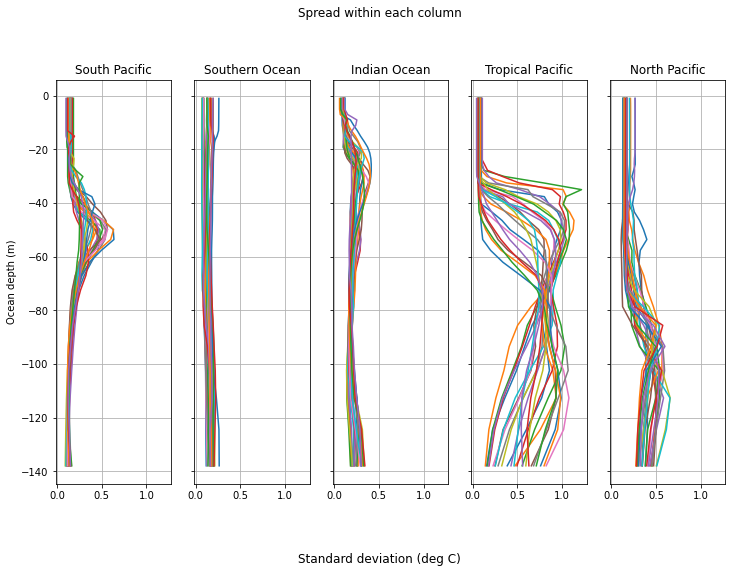

In [21]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot ocn temperature
axs[0].plot(sp_ocn_temp_std[:ind150m_ocn], -1 * sp_corr['ocn_lev'][:ind150m_ocn])
axs[1].plot(so_ocn_temp_std[:ind150m_ocn], -1 * so_corr['ocn_lev'][:ind150m_ocn])
axs[2].plot(io_ocn_temp_std[:ind150m_ocn], -1 * io_corr['ocn_lev'][:ind150m_ocn])
axs[3].plot(tp_ocn_temp_std[:ind150m_ocn], -1 * tp_corr['ocn_lev'][:ind150m_ocn])
axs[4].plot(np_ocn_temp_std[:ind150m_ocn], -1 * np_corr['ocn_lev'][:ind150m_ocn])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
axs[0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread within each column')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_std_bycolumn_ocn150m_five_columns')
plt.show()

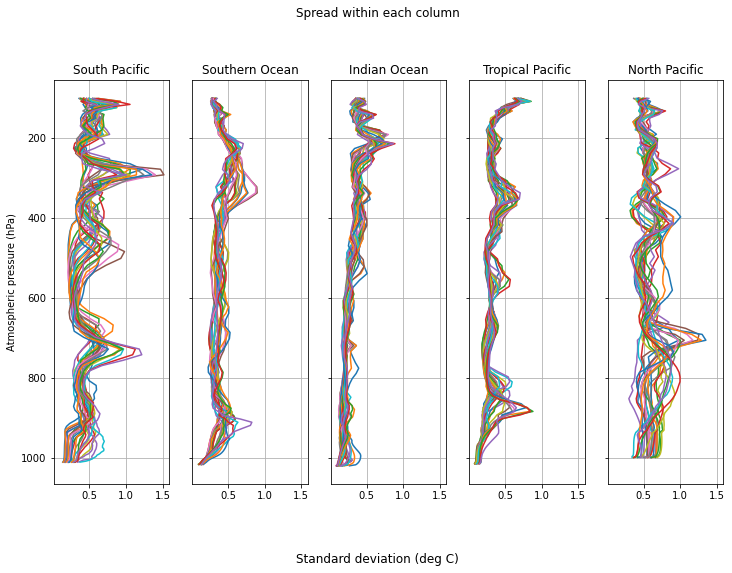

In [22]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot atm temperature spread
axs[0].plot(sp_atm_temp_std[ind100hPa:], sp_corr['atm_p'][ind100hPa:])
axs[1].plot(so_atm_temp_std[ind100hPa:], so_corr['atm_p'][ind100hPa:])
axs[2].plot(io_atm_temp_std[ind100hPa:], io_corr['atm_p'][ind100hPa:])
axs[3].plot(tp_atm_temp_std[ind100hPa:], tp_corr['atm_p'][ind100hPa:])
axs[4].plot(np_atm_temp_std[ind100hPa:], np_corr['atm_p'][ind100hPa:])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
plt.gca().invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread within each column')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_std_bycolumn_atm_five_columns')
plt.show()

### Spread within ensemble members

In [23]:
hold = south_pacific['ocn_Temp'] - south_pacific['ocn_Temp'].mean('ens_mem')

In [24]:
## Find perturbations in each column
def find_temp_perturbations(ds):
    ds['atm_T_pert'] = ds['atm_T'] - ds['atm_T'].mean('ens_mem')
    ds['ocn_Temp_pert'] = ds['ocn_Temp'] - ds['ocn_Temp'].mean('ens_mem')
    return ds
        

# Do for each location
south_pacific = find_temp_perturbations(south_pacific)
southern_ocean = find_temp_perturbations(southern_ocean)
indian_ocean =  find_temp_perturbations(indian_ocean)
tropical_pacific = find_temp_perturbations(tropical_pacific)
north_pacific = find_temp_perturbations(north_pacific)

In [25]:
## Plot spread in top 150 m of ocean
## Standard deviation of ensemble

# South Pacific
sp_ocn_temp_std_ens = south_pacific['ocn_Temp_pert'].std(['lat', 'lon']).to_numpy()
sp_ocn_temp_std_ens = sp_ocn_temp_std_ens.transpose()
sp_atm_temp_std_ens = south_pacific['atm_T_pert'].std(['lat', 'lon']).to_numpy()
sp_atm_temp_std_ens = sp_atm_temp_std_ens.transpose()

# Southern Ocean
so_ocn_temp_std_ens = southern_ocean['ocn_Temp_pert'].std(['lat', 'lon']).to_numpy()
so_ocn_temp_std_ens = so_ocn_temp_std_ens.transpose()
so_atm_temp_std_ens = southern_ocean['atm_T_pert'].std(['lat', 'lon']).to_numpy()
so_atm_temp_std_ens = so_atm_temp_std_ens.transpose()

# Indian Ocean
io_ocn_temp_std_ens = indian_ocean['ocn_Temp_pert'].std(['lat', 'lon']).to_numpy()
io_ocn_temp_std_ens = io_ocn_temp_std_ens.transpose()
io_atm_temp_std_ens = indian_ocean['atm_T_pert'].std(['lat', 'lon']).to_numpy()
io_atm_temp_std_ens = io_atm_temp_std_ens.transpose()

# Tropical Pacific
tp_ocn_temp_std_ens = tropical_pacific['ocn_Temp_pert'].std(['lat', 'lon']).to_numpy()
tp_ocn_temp_std_ens = tp_ocn_temp_std_ens.transpose()
tp_atm_temp_std_ens = tropical_pacific['atm_T_pert'].std(['lat', 'lon']).to_numpy()
tp_atm_temp_std_ens = tp_atm_temp_std_ens.transpose()

# North Pacific
np_ocn_temp_std_ens = north_pacific['ocn_Temp_pert'].std(['lat', 'lon']).to_numpy()
np_ocn_temp_std_ens = np_ocn_temp_std_ens.transpose()
np_atm_temp_std_ens = north_pacific['atm_T_pert'].std(['lat', 'lon']).to_numpy()
np_atm_temp_std_ens = np_atm_temp_std_ens.transpose()

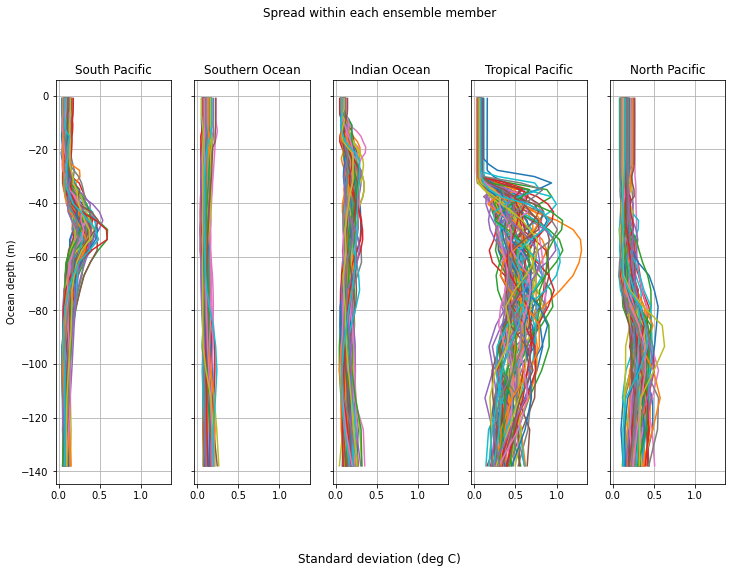

In [26]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot ocn temperature
axs[0].plot(sp_ocn_temp_std_ens[:ind150m_ocn], -1 * sp_corr['ocn_lev'][:ind150m_ocn])
axs[1].plot(so_ocn_temp_std_ens[:ind150m_ocn], -1 * so_corr['ocn_lev'][:ind150m_ocn])
axs[2].plot(io_ocn_temp_std_ens[:ind150m_ocn], -1 * io_corr['ocn_lev'][:ind150m_ocn])
axs[3].plot(tp_ocn_temp_std_ens[:ind150m_ocn], -1 * tp_corr['ocn_lev'][:ind150m_ocn])
axs[4].plot(np_ocn_temp_std_ens[:ind150m_ocn], -1 * np_corr['ocn_lev'][:ind150m_ocn])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
axs[0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread within each ensemble member')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_std_byensmem_ocn150m_five_columns')
plt.show()

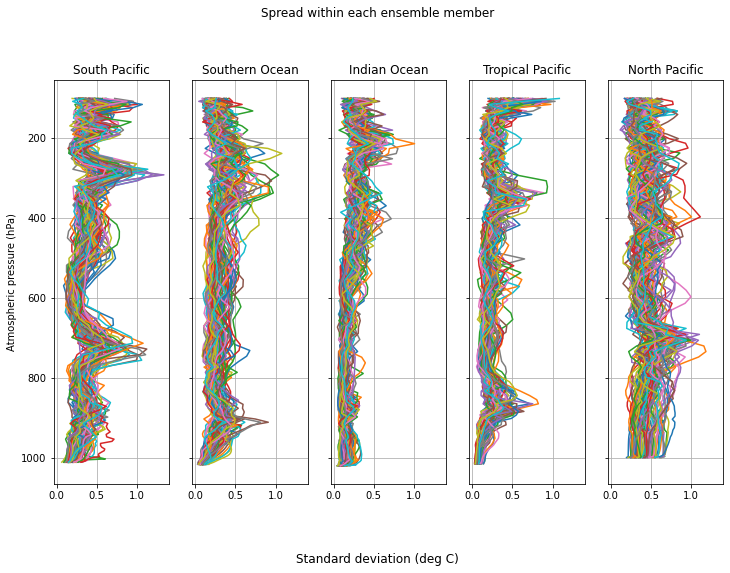

In [27]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot atm temperature spread
axs[0].plot(sp_atm_temp_std_ens[ind100hPa:], sp_corr['atm_p'][ind100hPa:])
axs[1].plot(so_atm_temp_std_ens[ind100hPa:], so_corr['atm_p'][ind100hPa:])
axs[2].plot(io_atm_temp_std_ens[ind100hPa:], io_corr['atm_p'][ind100hPa:])
axs[3].plot(tp_atm_temp_std_ens[ind100hPa:], tp_corr['atm_p'][ind100hPa:])
axs[4].plot(np_atm_temp_std_ens[ind100hPa:], np_corr['atm_p'][ind100hPa:])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
axs[0].invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread within each ensemble member')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_std_byensmem_atm_five_columns')
plt.show()

### Plot spread in bootstrapped ensemble

In [28]:
# Plot spread by vertical level in the ocean, to 150 m
sp_spread = np.sqrt(np.diag(sp_cov))
so_spread = np.sqrt(np.diag(so_cov))
io_spread = np.sqrt(np.diag(io_cov))
tp_spread = np.sqrt(np.diag(tp_cov))
np_spread = np.sqrt(np.diag(np_cov))

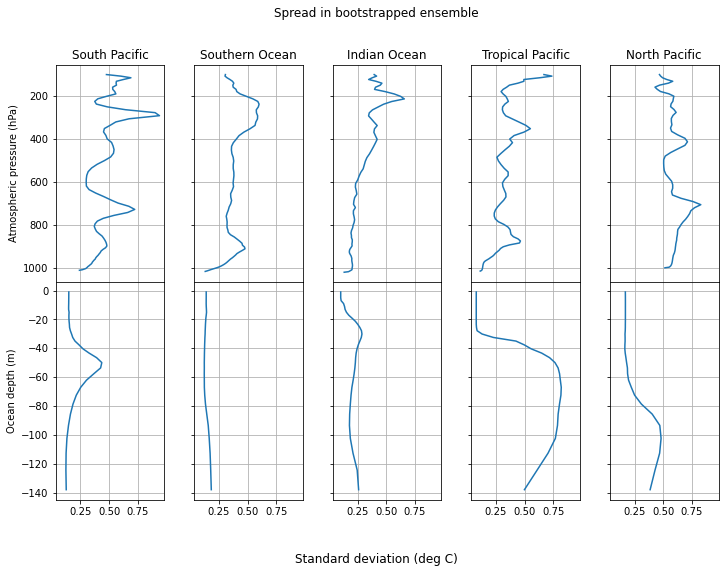

In [29]:
## Create subplots
fig, axs = plt.subplots(nrows=2, ncols=5, sharey='row', sharex=True) 

# Plot atm temperature
axs[0,0].plot(sp_spread[ind100hPa:ind0m], sp_corr['atm_p'][ind100hPa:])
axs[0,1].plot(so_spread[ind100hPa:ind0m], so_corr['atm_p'][ind100hPa:])
axs[0,2].plot(io_spread[ind100hPa:ind0m], io_corr['atm_p'][ind100hPa:])
axs[0,3].plot(tp_spread[ind100hPa:ind0m], tp_corr['atm_p'][ind100hPa:])
axs[0,4].plot(np_spread[ind100hPa:ind0m], np_corr['atm_p'][ind100hPa:])

# Plot ocn temperature
axs[1,0].plot(sp_spread[ind0m:ind150m], -1 * sp_corr['ocn_lev'][:ind150m_ocn])
axs[1,1].plot(so_spread[ind0m:ind150m], -1 * so_corr['ocn_lev'][:ind150m_ocn])
axs[1,2].plot(io_spread[ind0m:ind150m], -1 * io_corr['ocn_lev'][:ind150m_ocn])
axs[1,3].plot(tp_spread[ind0m:ind150m], -1 * tp_corr['ocn_lev'][:ind150m_ocn])
axs[1,4].plot(np_spread[ind0m:ind150m], -1 * np_corr['ocn_lev'][:ind150m_ocn])

# Set titles
axs[0,0].set_title('South Pacific')
axs[0,1].set_title('Southern Ocean')
axs[0,2].set_title('Indian Ocean')
axs[0,3].set_title('Tropical Pacific')
axs[0,4].set_title('North Pacific')

# Adjust and label axes
axs[0,0].invert_yaxis()
axs[0,0].set_ylabel('Atmospheric pressure (hPa)')
axs[1,0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread in bootstrapped ensemble')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_spread_in_bootstrapped_ens_five_columns')
plt.show()

### Decomposing the spread in the bootstrapped ensemble

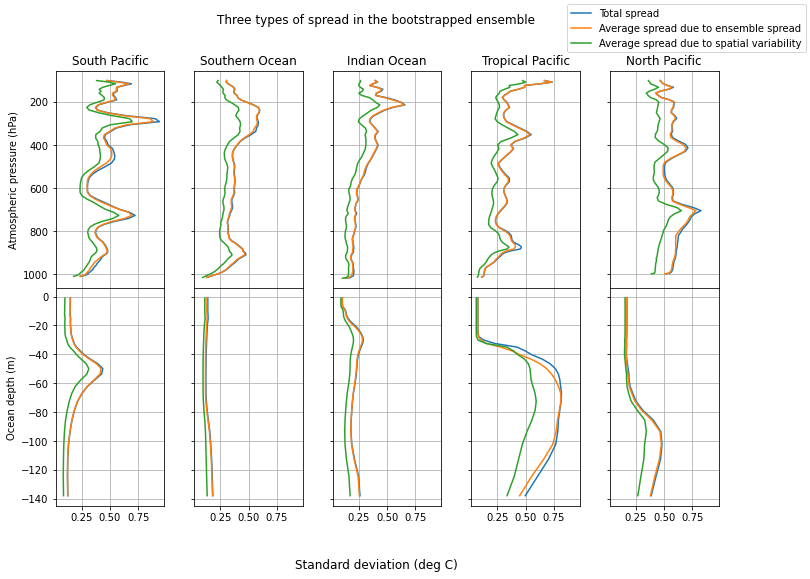

In [30]:
## Create subplots
fig, axs = plt.subplots(nrows=2, ncols=5, sharey='row', sharex=True) 

# Plot atm total spread
axs[0,0].plot(sp_spread[ind100hPa:ind0m], sp_corr['atm_p'][ind100hPa:], label='Total spread')
axs[0,1].plot(so_spread[ind100hPa:ind0m], so_corr['atm_p'][ind100hPa:])
axs[0,2].plot(io_spread[ind100hPa:ind0m], io_corr['atm_p'][ind100hPa:])
axs[0,3].plot(tp_spread[ind100hPa:ind0m], tp_corr['atm_p'][ind100hPa:])
axs[0,4].plot(np_spread[ind100hPa:ind0m], np_corr['atm_p'][ind100hPa:])

# Plot atm spread due to ensemble var
axs[0,0].plot(sp_atm_temp_std[ind100hPa:].mean(axis=1), sp_corr['atm_p'][ind100hPa:], label='Average spread due to ensemble spread')
axs[0,1].plot(so_atm_temp_std[ind100hPa:].mean(axis=1), so_corr['atm_p'][ind100hPa:])
axs[0,2].plot(io_atm_temp_std[ind100hPa:].mean(axis=1), io_corr['atm_p'][ind100hPa:])
axs[0,3].plot(tp_atm_temp_std[ind100hPa:].mean(axis=1), tp_corr['atm_p'][ind100hPa:])
axs[0,4].plot(np_atm_temp_std[ind100hPa:].mean(axis=1), np_corr['atm_p'][ind100hPa:])


# Plot atm spread due to spatial variability
axs[0,0].plot(sp_atm_temp_std_ens[ind100hPa:].mean(axis=1), sp_corr['atm_p'][ind100hPa:], label='Average spread due to spatial variability')
axs[0,1].plot(so_atm_temp_std_ens[ind100hPa:].mean(axis=1), so_corr['atm_p'][ind100hPa:])
axs[0,2].plot(io_atm_temp_std_ens[ind100hPa:].mean(axis=1), io_corr['atm_p'][ind100hPa:])
axs[0,3].plot(tp_atm_temp_std_ens[ind100hPa:].mean(axis=1), tp_corr['atm_p'][ind100hPa:])
axs[0,4].plot(np_atm_temp_std_ens[ind100hPa:].mean(axis=1), np_corr['atm_p'][ind100hPa:])

# Plot ocn total spread
axs[1,0].plot(sp_spread[ind0m:ind150m], -1 * sp_corr['ocn_lev'][:ind150m_ocn])
axs[1,1].plot(so_spread[ind0m:ind150m], -1 * so_corr['ocn_lev'][:ind150m_ocn])
axs[1,2].plot(io_spread[ind0m:ind150m], -1 * io_corr['ocn_lev'][:ind150m_ocn])
axs[1,3].plot(tp_spread[ind0m:ind150m], -1 * tp_corr['ocn_lev'][:ind150m_ocn])
axs[1,4].plot(np_spread[ind0m:ind150m], -1 * np_corr['ocn_lev'][:ind150m_ocn])

# Plot ocn spread due to ensemble var
axs[1,0].plot(sp_ocn_temp_std[:ind150m_ocn].mean(axis=1), -1 * sp_corr['ocn_lev'][:ind150m_ocn])
axs[1,1].plot(so_ocn_temp_std[:ind150m_ocn].mean(axis=1), -1 * so_corr['ocn_lev'][:ind150m_ocn])
axs[1,2].plot(io_ocn_temp_std[:ind150m_ocn].mean(axis=1), -1 * io_corr['ocn_lev'][:ind150m_ocn])
axs[1,3].plot(tp_ocn_temp_std[:ind150m_ocn].mean(axis=1), -1 * tp_corr['ocn_lev'][:ind150m_ocn])
axs[1,4].plot(np_ocn_temp_std[:ind150m_ocn].mean(axis=1), -1 * np_corr['ocn_lev'][:ind150m_ocn])

# Plot ocn spread due to spatial variability
axs[1,0].plot(sp_ocn_temp_std_ens[:ind150m_ocn].mean(axis=1), -1 * sp_corr['ocn_lev'][:ind150m_ocn])
axs[1,1].plot(so_ocn_temp_std_ens[:ind150m_ocn].mean(axis=1), -1 * so_corr['ocn_lev'][:ind150m_ocn])
axs[1,2].plot(io_ocn_temp_std_ens[:ind150m_ocn].mean(axis=1), -1 * io_corr['ocn_lev'][:ind150m_ocn])
axs[1,3].plot(tp_ocn_temp_std_ens[:ind150m_ocn].mean(axis=1), -1 * tp_corr['ocn_lev'][:ind150m_ocn])
axs[1,4].plot(np_ocn_temp_std_ens[:ind150m_ocn].mean(axis=1), -1 * np_corr['ocn_lev'][:ind150m_ocn])

# Set titles
axs[0,0].set_title('South Pacific')
axs[0,1].set_title('Southern Ocean')
axs[0,2].set_title('Indian Ocean')
axs[0,3].set_title('Tropical Pacific')
axs[0,4].set_title('North Pacific')

# Adjust and label axes
axs[0,0].invert_yaxis()
axs[0,0].set_ylabel('Atmospheric pressure (hPa)')
axs[1,0].set_ylabel('Ocean depth (m)')
fig.legend()
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Three types of spread in the bootstrapped ensemble')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_spread_decomposition_five_columns')
plt.show()

### Plot covariance matrices

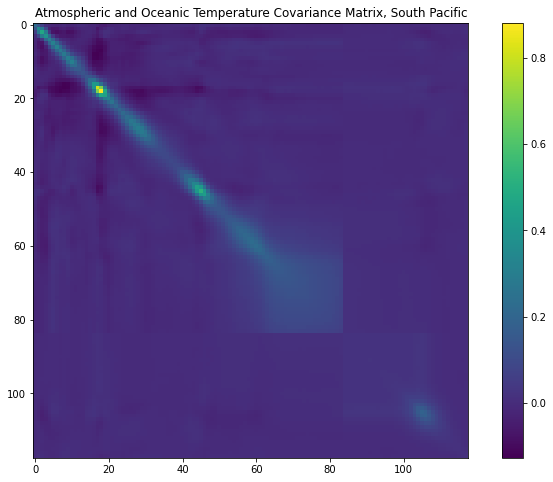

In [31]:
# Plot covariance matrices
this_cov = sp_cov[ind100hPa:ind150m, ind100hPa:ind150m]
fullname = 'South Pacific'
short_name = 'south_pacific'
plt.imshow(this_cov)
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Covariance Matrix, '+fullname)
plt.savefig(plot_dir+'/cov_atm_ocn_temperature_'+short_name+'.png')

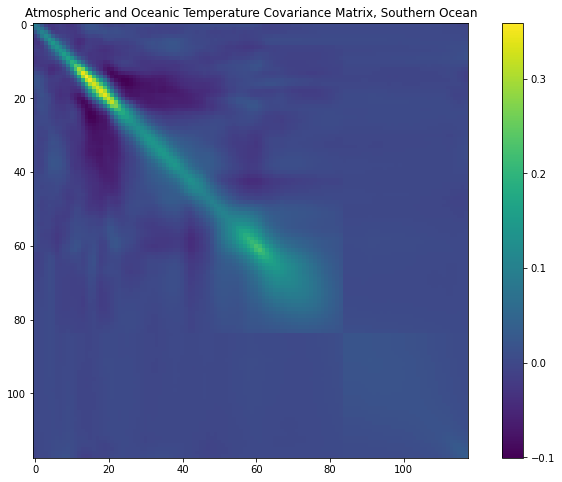

In [32]:
# Plot covariance matrices
this_cov = so_cov[ind100hPa:ind150m, ind100hPa:ind150m]
fullname = 'Southern Ocean'
short_name = 'southern_ocean'
plt.imshow(this_cov)
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Covariance Matrix, '+fullname)
plt.savefig(plot_dir+'/cov_atm_ocn_temperature_'+short_name+'.png')

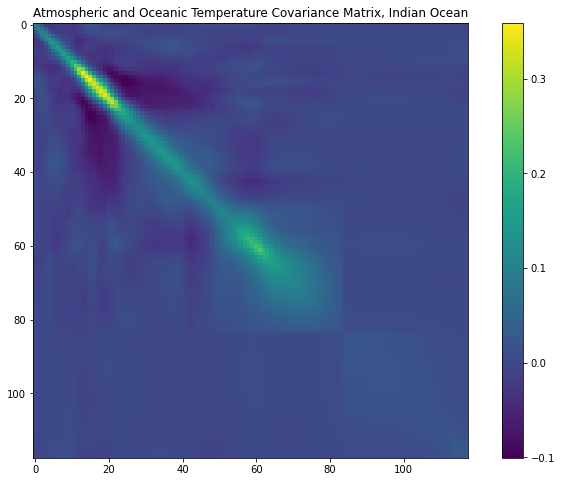

In [33]:
# Plot covariance matrices
this_cov = so_cov[ind100hPa:ind150m, ind100hPa:ind150m]
fullname = 'Indian Ocean'
short_name = 'indian_ocean'
plt.imshow(this_cov)
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Covariance Matrix, '+fullname)
plt.savefig(plot_dir+'/cov_atm_ocn_temperature_'+short_name+'.png')

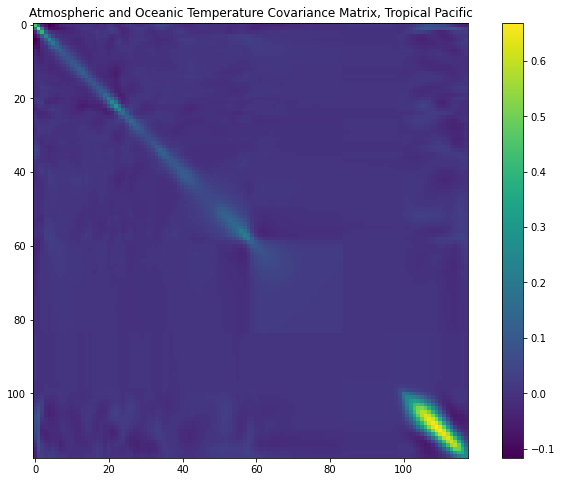

In [34]:
# Plot covariance matrices
this_cov = tp_cov[ind100hPa:ind150m, ind100hPa:ind150m]
fullname = 'Tropical Pacific'
short_name = 'tropical_pacific'
plt.imshow(this_cov)
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Covariance Matrix, '+fullname)
plt.savefig(plot_dir+'/cov_atm_ocn_temperature_'+short_name+'.png')

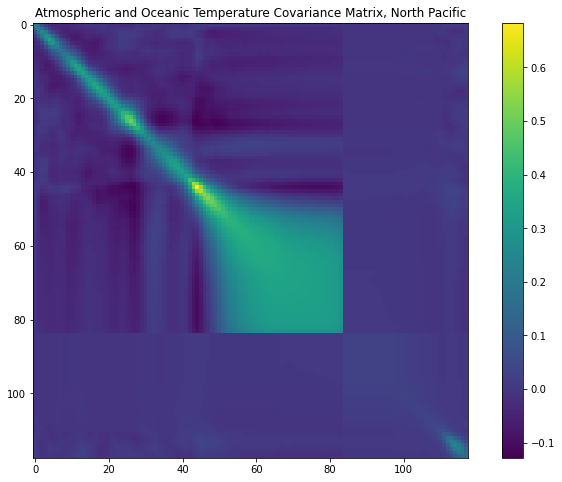

In [35]:
# Plot covariance matrices
this_cov = np_cov[ind100hPa:ind150m, ind100hPa:ind150m]
fullname = 'North Pacific'
short_name = 'north_pacific'
plt.imshow(this_cov)
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Covariance Matrix, '+fullname)
plt.savefig(plot_dir+'/cov_atm_ocn_temperature_'+short_name+'.png')

### Plot correlation matrices

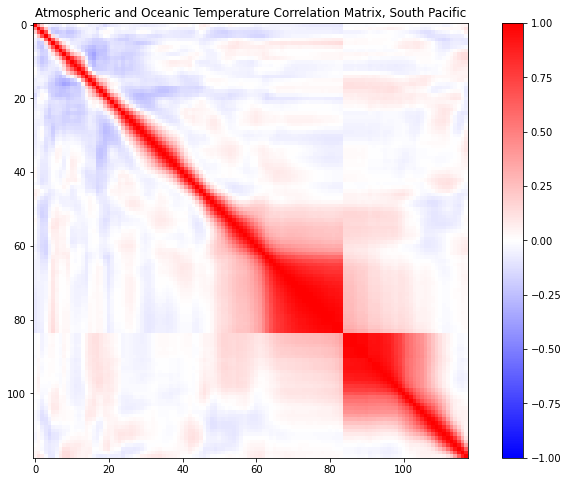

In [36]:
# Plot correlation matrices
this_cor = sp_cor[ind100hPa:ind150m, ind100hPa:ind150m]
fullname = 'South Pacific'
short_name = 'south_pacific'
plt.imshow(this_cor,  vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Correlation Matrix, '+fullname)
plt.savefig(plot_dir+'/cor_atm_ocn_temperature_'+short_name+'.png')

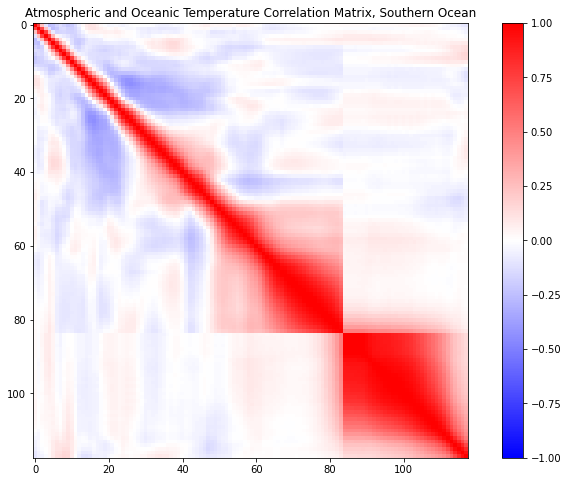

In [37]:
# Plot correlation matrices
this_cor = so_cor[ind100hPa:ind150m, ind100hPa:ind150m]
fullname = 'Southern Ocean'
short_name = 'southern_ocean'
plt.imshow(this_cor,  vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Correlation Matrix, '+fullname)
plt.savefig(plot_dir+'/cor_atm_ocn_temperature_'+short_name+'.png')

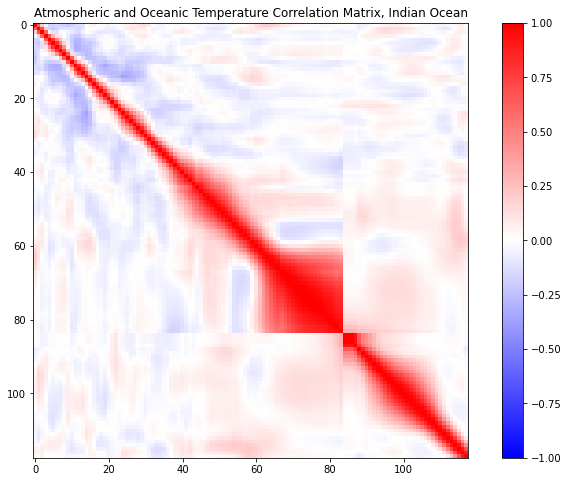

In [38]:
# Plot correlation matrices
this_cor = io_cor[ind100hPa:ind150m, ind100hPa:ind150m]
fullname = 'Indian Ocean'
short_name = 'indian_ocean'
plt.imshow(this_cor,  vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Correlation Matrix, '+fullname)
plt.savefig(plot_dir+'/cor_atm_ocn_temperature_'+short_name+'.png')

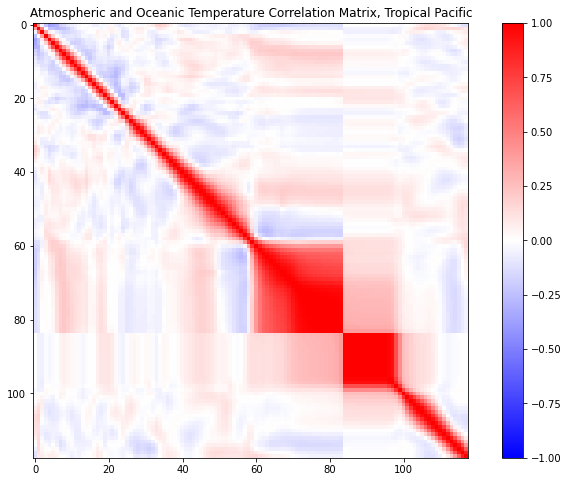

In [39]:
# Plot correlation matrices
this_cor = tp_cor[ind100hPa:ind150m, ind100hPa:ind150m]
fullname = 'Tropical Pacific'
short_name = 'tropical_pacific'
plt.imshow(this_cor,  vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Correlation Matrix, '+fullname)
plt.savefig(plot_dir+'/cor_atm_ocn_temperature_'+short_name+'.png')

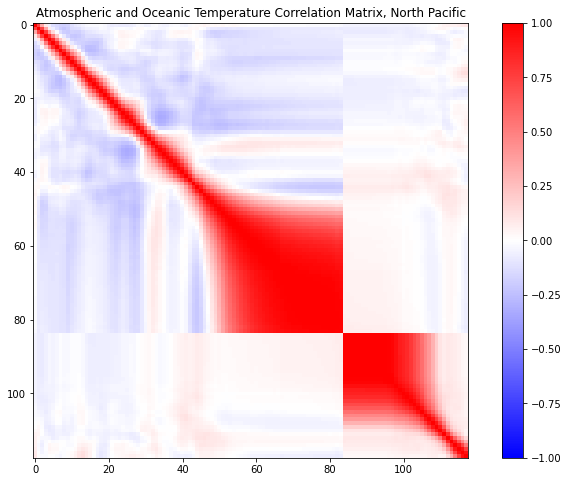

In [40]:
# Plot correlation matrices
this_cor = np_cor[ind100hPa:ind150m, ind100hPa:ind150m]
fullname = 'North Pacific'
short_name = 'north_pacific'
plt.imshow(this_cor,  vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Correlation Matrix, '+fullname)
plt.savefig(plot_dir+'/cor_atm_ocn_temperature_'+short_name+'.png')

### Check to see if southern ocean is freshwater lens generated from ice melt 

In [41]:
so_lat = southern_ocean['lat'].median()
so_lon = southern_ocean['lon'].median()

In [42]:
## Check to see if southern ocean is freshwater lens generated from ice melt 
## that creates a shallow barrier layer on the surface which makes the ocean more responsive
## to atm perts
so_salt_mean = southern_ocean['ocn_Salt'].sel(lon=so_lon, lat=so_lat).mean(['ens_mem'])
so_temp_mean = southern_ocean['ocn_Temp'].sel(lon=so_lon, lat=so_lat).mean(['ens_mem'])
southern_ocean['ocn_Dens'] = dens_wright_eos(southern_ocean['ocn_Temp'], southern_ocean['ocn_Salt'], 0)
so_dens_mean = southern_ocean['ocn_Dens'].sel(lon=so_lon, lat=so_lat).mean(['ens_mem'])

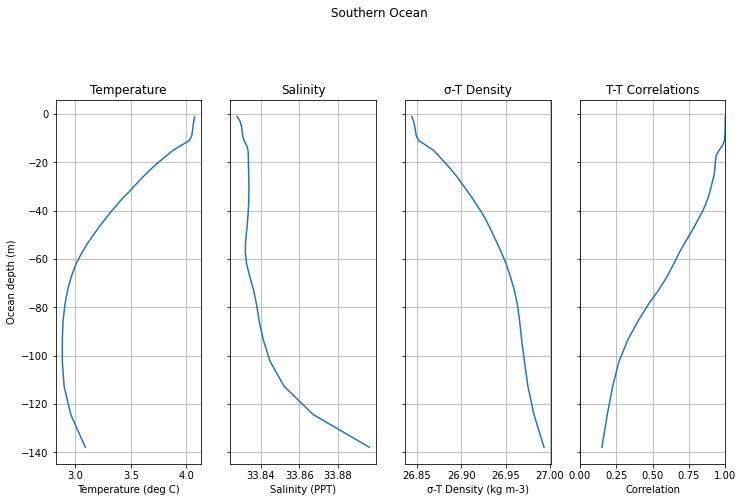

In [43]:
## Create subplots
fig, axs = plt.subplots(ncols=4, sharey=True) 

# Plot ocn states
axs[0].plot(so_temp_mean[:ind150m_ocn], -1 * sp_corr['ocn_lev'][:ind150m_ocn])
axs[1].plot(so_salt_mean[:ind150m_ocn], -1 * so_corr['ocn_lev'][:ind150m_ocn])
axs[2].plot(so_dens_mean[:ind150m_ocn]-1000, -1 * so_corr['ocn_lev'][:ind150m_ocn])
axs[3].plot(so_corr['sst_ocn_T'][:ind150m_ocn], -1 * io_corr['ocn_lev'][:ind150m_ocn])


# Set titles
axs[0].set_title('Temperature')
axs[1].set_title('Salinity')
axs[2].set_title('\u03C3-T Density')
axs[3].set_title('T-T Correlations')


# Adjust and label axes
axs[0].set_ylabel('Ocean depth (m)')
axs[0].set_xlabel('Temperature (deg C)')
axs[1].set_xlabel('Salinity (PPT)')
axs[2].set_xlabel('\u03C3-T Density (kg m-3)')
axs[3].set_xlabel('Correlation')
axs[3].set_xlim([0,1])
fig.suptitle('Southern Ocean')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/southern_ocean_temp_salt_dens_corr')
plt.show()